In [5]:
import numpy as np
import os

from matplotlib import pyplot as plt

import pydot

from IPython.display import SVG, display

from pydrake.common import temp_directory
from pydrake.geometry import (
    MeshcatVisualizer,
    MeshcatVisualizerParams,
    Role,
    StartMeshcat,
)

from pydrake.math import RigidTransform, RollPitchYaw
from pydrake.multibody.parsing import Parser
from pydrake.multibody.plant import AddMultibodyPlantSceneGraph
from pydrake.systems.analysis import Simulator
from pydrake.systems.framework import DiagramBuilder
from pydrake.visualization import ModelVisualizer
from pydrake.systems.primitives import LogVectorOutput
from pydrake.systems.controllers import PidController

test_mode = True if "TEST_SRCDIR" in os.environ else False

In [7]:
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7001


In [10]:
# Define a simple cylinder model.
pendulum_sdf = """<?xml version="1.0"?>
<sdf version="1.7">
  <model name="pendulum">
    <pose>0 0 0 0 0 0</pose>
    <link name = "pendulum_link">
      <inertial>
        <mass>1.0</mass>
      </inertial>
      <visual name="base">
        <geometry>
          <cylinder>
            <radius>0.1</radius>
            <length>1.0</length>
          </cylinder>
        </geometry>
      </visual>
      <collision name="base_col">
        <geometry>
          <cylinder>
            <radius>0.1</radius>
            <length>1.0</length>
          </cylinder>
        </geometry>
      </collision>
    </link>

    <link name = "pendulum_link_2">
      <pose>0 0 -1.0 0 0 0</pose>
      <inertial>
        <mass>1.0</mass>
      </inertial>
      <visual name="base">
        <geometry>
          <cylinder>
            <radius>0.1</radius>
            <length>1.0</length>
          </cylinder>
        </geometry>
      </visual>
      <collision name="base_col">
        <geometry>
          <cylinder>
            <radius>0.1</radius>
            <length>1.0</length>
          </cylinder>
        </geometry>
      </collision>
    </link>

    <joint name="world_to_upper_pin_joint" type="revolute">
      <parent>world</parent>
      <child>pendulum_link</child>
      <pose>0 0 0.5 0 0 0</pose>
      <axis>
        <!-- spins about x axis -->
        <xyz>1 0 0</xyz>
      </axis>
    </joint>

    <joint name="upper_pin_to_lower_pin_joint" type="revolute">
      <parent>pendulum_link</parent>
      <child>pendulum_link_2</child>
      <pose>0 0 0.5 0 0 0</pose>
      <axis>
        <!-- spins about x axis -->
        <xyz>1 0 0</xyz>
      </axis>
    </joint>


  </model>
</sdf>
"""

table_top_sdf = """<?xml version="1.0"?>
<sdf version="1.7">
  <model name="table_top">
    <link name="table_top_link">
      <visual name="visual">
        <pose>0 0 0 0 0 0</pose>
        <geometry>
          <box>
            <size>0.55 1.1 0.05</size>
          </box>
        </geometry>
        <material>
         <diffuse>0.9 0.8 0.7 1.0</diffuse>
        </material>
      </visual>
      <collision name="collision">
        <pose>0 0 0 0 0 0</pose>
        <geometry>
          <box>
            <size>0.55 1.1 0.05</size>
          </box>
        </geometry>
      </collision>
    </link>
    <frame name="table_top_center">
      <pose relative_to="table_top_link">0 0 0 0 0 0</pose>
    </frame>
  </model>
</sdf>

"""

# Visualize the cylinder from the SDFormat string you just defined.
visualizer = ModelVisualizer(meshcat=meshcat)
visualizer.parser().AddModelsFromString(pendulum_sdf, "sdf")
# visualizer.parser().AddModelsFromString(table_top_sdf, "sdf")

# Click the "Stop Running" button in MeshCat when you're finished.
visualizer.Run(loop_once=test_mode)

Click 'Stop Running' or press Esc to quit


<RunResult.STOPPED: 2>

In [153]:
def create_scene(sim_time_step = 0.0001):

    meshcat.Delete()
    meshcat.DeleteAddedControls()

    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(
        builder, time_step = sim_time_step
    )
    parser = Parser(plant)

    parser.AddModelsFromString(pendulum_sdf, "sdf")
    # parser.AddModelsFromString(table_top_sdf, "sdf")

    # table_frame = plant.GetFrameByName("table_top_center")
    # plant.WeldFrames(plant.world_frame(), table_frame)

    plant.Finalize()
    plant_context = plant.CreateDefaultContext()

    # Add a PID controller.
    # controller = builder.AddNamedSystem("controller",
    #                                 PidController(kp=[12.], ki=[1.], kd=[1.]))
    
    # builder.Connect(plant.get_state_output_port(),
    #             controller.get_input_port_estimated_state())
    # builder.Connect(controller.get_output_port_control(), plant.get_actuation_input_port())

    # builder.ExportInput(controller.get_input_port_desired_state())

    # plant.get_actuation_input_port().FixValue(plant_context, np.zeros(plant.num_actuators()))

    # cylinder = plant.GetBodyByName("cylinder_link")
    # X_WorldTable = table_frame.CalcPoseInWorld(plant_context)
    # X_TableCylinder = RigidTransform(
    #     RollPitchYaw(np.asarray([90, 0, 0]) * np.pi / 180), p = [0,0,1.0]
    # )
    # X_WorldCylinder = X_WorldTable.multiply(X_TableCylinder)
    # plant.SetDefaultFreeBodyPose(cylinder, X_WorldCylinder)

    logger = LogVectorOutput(plant.get_state_output_port(), builder)
    logger.set_name("logger")

    visualizer = MeshcatVisualizer.AddToBuilder(
        builder, scene_graph, meshcat,
        MeshcatVisualizerParams(role = Role.kPerception, prefix="visual")
    )

    diagram = builder.Build()

    return diagram, visualizer, plant, logger




In [5]:
diagram, visualizer, plant = create_scene(sim_time_step=0.0001)

In [122]:
from pydrake.multibody.tree import RigidBody

cylinder_body = plant.GetRigidBodyByName("cylinder_link")

def print_spatial_inertia_params(body):
    spatial_inertia = cylinder_body.default_spatial_inertia()
    print("Spatial Inertia Parameters for:", cylinder_body.name())
    print("Mass", spatial_inertia.get_mass())
    print("COM", spatial_inertia.get_com())
    print("Unit Inertia", spatial_inertia.get_unit_inertia().CopyToFullMatrix3())

def print_spatial_inertia_params(body, context):
    spatial_inertia = cylinder_body.CalcSpatialInertiaInBodyFrame(context)
    print("Spatial Inertia Parameters for:", cylinder_body.name())
    print("Mass", spatial_inertia.get_mass())
    print("COM", spatial_inertia.get_com())
    print("Unit Inertia", spatial_inertia.get_unit_inertia().CopyToFullMatrix3())

default_context = plant.CreateDefaultContext()
print_spatial_inertia_params(cylinder_body, default_context)

adjusted_context = plant.CreateDefaultContext()
RigidBody.SetMass(cylinder_body, adjusted_context, 0.1)
print_spatial_inertia_params(cylinder_body, adjusted_context)

NameError: name 'plant' is not defined

[0.0, 0.0]
::_ Context (of a Diagram)
---------------------------
1 total continuous states
2 total discrete states in 1 groups
58 total numeric parameters in 7 groups
2 total abstract parameters

::_::plant Context
-------------------
Time: 0
States:
  1 discrete state groups with
     2 states
       0 0

Parameters:
  7 numeric parameter groups with
     1 parameters
       0
     1 parameters
       1
     10 parameters
       nan nan nan nan nan nan nan nan nan nan
     10 parameters
        10   0   0   0 0.1 0.1 0.1   0   0   0
     12 parameters
       1 0 0 0 1 0 0 0 1 0 0 0
     12 parameters
         1   0   0   0   1   0   0   0   1   0   0 0.5
     12 parameters
         1   0   0   0   1   0   0   0   1   0   0 0.5
  1 abstract parameters

::_::scene_graph Context
-------------------------
Time: 0
Parameters:
  1 abstract parameters

::_::controller Context
------------------------
Time: 0
States:
  1 continuous states
    0




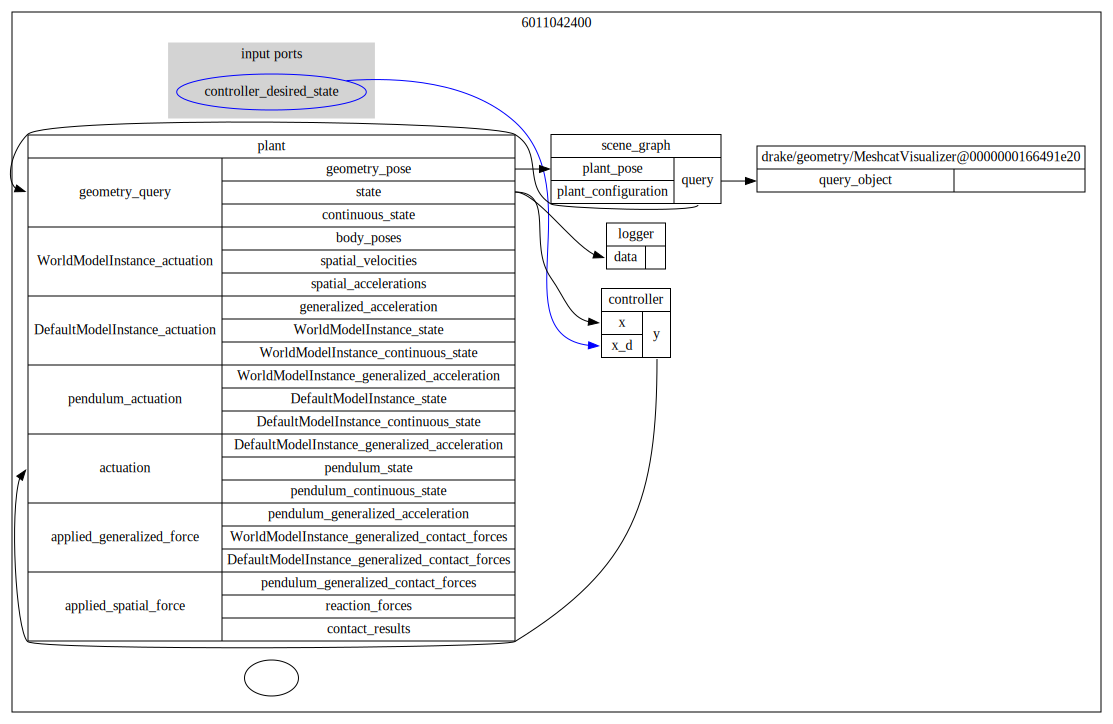

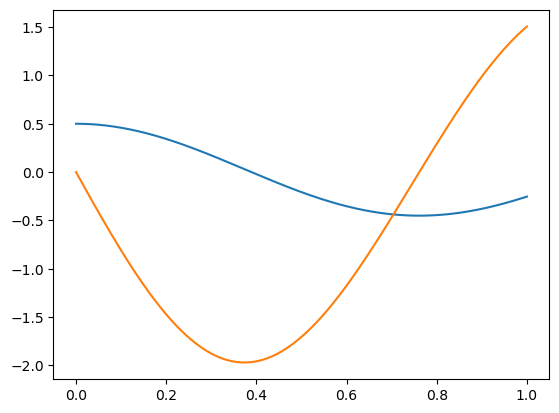

In [154]:
def initialize_simulation(diagram, plant):
    simulator = Simulator(diagram)

    context = simulator.get_mutable_context()
    default_state_vector = context.get_mutable_discrete_state_vector()
    print(default_state_vector)

    cylinder_body = plant.GetRigidBodyByName("pendulum_link")
    RigidBody.SetMass(cylinder_body, context, 10.)

    print(context)
    context.SetDiscreteState(np.array([0.5, 0]))

    diagram.get_input_port(0).FixValue(context, [0.0, 0.])

    # Fix input port to zero
    # plant_context = diagram.GetMutableSubsystemContext(
    #     plant, simulator.get_mutable_context()
    # )
    # plant.get_actuation_input_port().FixValue(
    #     plant_context, np.zeros(plant.num_actuators())
    # )

    display(SVG(pydot.graph_from_dot_data(
        diagram.GetGraphvizString(max_depth=2))[0].create_svg()))

    simulator.Initialize()
    simulator.set_target_realtime_rate(1,)
    return simulator

def run_simulation(sim_time_step):
    diagram, visualizer, plant, logger = create_scene(sim_time_step)
    simulator = initialize_simulation(diagram, plant)
    visualizer.StartRecording()
    simulator.AdvanceTo(1.0)
    visualizer.PublishRecording

    log = logger.FindLog(simulator.get_context())
    t = log.sample_times()

    plt.figure()
    plt.plot(t, log.data()[0,:])
    plt.plot(t, log.data()[1,:])

run_simulation(sim_time_step=0.0001)

In [157]:
np.random.randn(2) * np.array([1, 100])

array([-8.36216447e-02, -1.23177281e+02])

In [3]:
import numpy as np
np.maximum([1,1,1], [0,0,0])
np.maximum([1,1,1], [0,0,0])

array([1, 1, 1])